# Miconi network

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/Miconi.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/Miconi.ipynb)

In [1]:
#!pip install ANNarchy



Reward-modulated recurrent network based on:

> Miconi T. (2017). Biologically plausible learning in recurrent neural networks reproduces neural dynamics observed during cognitive tasks. eLife 6:e20899. doi:10.7554/eLife.20899

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import ANNarchy as ann

ANNarchy 4.8 (4.8.3) on darwin (posix).


Each neuron in the reservoir follows the following equations:

$$
    \tau \frac{dx(t)}{dt} + x(t) = \sum_\text{input} W^\text{IN} \, r^\text{IN}(t) + \sum_\text{rec} W^\text{REC} \, r(t) + \xi(t)
$$

$$
    r(t) = \tanh(x(t))
$$

where $\xi(t)$ is a random perturbation at 3 Hz, with an amplitude randomly sampled between $-A$ and $+A$.

We additionally keep track of the mean firing rate with a sliding average:

$$
    \tilde{x}(t) = \alpha \, \tilde{x}(t) + (1 - \alpha) \, x(t)
$$

The three first neurons keep a constant rate throughout learning (1 or -1) to provide some bias to the other neurons.

In [3]:
neuron = ann.Neuron(
    parameters = dict(
        tau = 30.0, # Time constant
        constant = ann.parameter(0.0, 'local'), # The four first neurons have constant rates
        alpha = 0.05, # To compute the sliding mean
        f = 3.0, # Frequency of the perturbation
        A = 16., # Perturbation amplitude. dt*A/tau should be 0.5...
    ),
    equations = [
        # Perturbation
        'perturbation = if Uniform(0.0, 1.0) < f/1000.: 1.0 else: 0.0',
        'noise = if perturbation > 0.5: A * Uniform(-1.0, 1.0) else: 0.0',

        # ODE for x
        'x += dt*(sum(in) + sum(exc) - x + noise)/tau',

        # Output r
        'rprev = r', # store r at previous time step
        'r = if constant == 0.0: tanh(x) else: tanh(constant)',

        # Sliding mean
        'delta_x = x - x_mean',
        'x_mean = alpha * x_mean + (1 - alpha) * x',
    ]
)

The learning rule is defined by a trace $e_{i, j}(t)$ for each synapse $i \rightarrow j$ incremented at each time step with:

$$
    e_{i, j}(t) = e_{i, j}(t-1) + (r_i (t) \, x_j(t))^3
$$

At the end $T$ of a trial, the reward $R$ is delivered and all weights are updated using:

$$
    \Delta w_{i, j} = \eta \,  e_{i, j}(T) \, |R_\text{mean}| \,  (R - R_\text{mean})
$$

where $R_\text{mean}$ is the mean reward for the task. Here the reward is defined as the opposite of the prediction error.

All traces are then reset to 0 for the next trial. Weight changes are clamped between -0.0003 and 0.0003.

As ANNarchy applies the synaptic equations at each time step, we need to introduce a global boolean `learning_phase` which performs trace integration when false, and allows weight update when true.

In [4]:
synapse = ann.Synapse(
    parameters=dict(
        eta = 0.5, # Learning rate
        max_weight_change = 0.0003, # Clip the weight changes

        # Flag to allow learning only at the end of a trial
        learning_phase = ann.parameter(False, 'global', 'bool'), 
        reward = 0.0, # Reward received
        mean_reward = 0.0, # Mean Reward received
    ),
    equations = [
        # Trace
        """
        trace += if not(learning_phase):
                    power(pre.rprev * (post.delta_x), 3)
                 else:
                    0.0
        """,

        # Weight update only at the end of the trial
        ann.variable("""
            delta_w = if learning_phase:
                    eta * trace * fabs(mean_reward) * (reward - mean_reward)
                else:
                    0.0 
        """, 
        min='-max_weight_change', max='max_weight_change'),

        # Weight update
        "w += delta_w",
        
    ]
)

We implement the network as a class deriving from `ann.Network`. The network has two inputs A and B, so we create the corresponding static population. The reservoir has 200 neurons, 3 of which having constant rates to serve as biases for the other neurons. 

Input weights are uniformly distributed between -1 and 1.

The recurrent weights are normally distributed, with a coupling strength of $g=1.5$ (edge of chaos). In the original paper, the projection is fully connected (but self-connections are avoided). Using a sparse (0.1) connectivity matrix leads to similar results and is much faster.

In [5]:
class MiconiNetwork (ann.Network):

    def __init__(self, N, g, sparseness):

        # Input population
        self.inp = self.create(2, ann.Neuron("r=0.0"))

        # Recurrent population
        self.pop = self.create(N, neuron)

        # Biases
        self.pop[0].constant = 1.0
        self.pop[1].constant = 1.0
        self.pop[2].constant = -1.0

        # Input weights
        self.Wi = self.connect(self.inp, self.pop, 'in')
        self.Wi.connect_all_to_all(weights=ann.Uniform(-1.0, 1.0))

        # Recurrent weights
        self.Wrec = self.connect(self.pop, self.pop, 'exc', synapse)
        if sparseness == 1.0:
            self.Wrec.connect_all_to_all(weights=ann.Normal(0., g/np.sqrt(N)))
        else:
            self.Wrec.connect_fixed_probability(probability=sparseness, weights=ann.Normal(0., g/np.sqrt(sparseness*N)))

        # Monitor
        self.m = self.monitor(self.pop, ['r'], start=False)

In [6]:
net = MiconiNetwork(N=200, g=1.5, sparseness=0.1)
net.compile()

The output of the reservoir is chosen to be the neuron of index 100.

In [7]:
OUTPUT_NEURON = 100

Parameters defining the task:

In [8]:
# Durations
d_stim = 200
d_delay= 200
d_response = 200

Definition of a DNMS trial (AA, AB, BA, BB):

In [9]:
def dnms_trial(trial_number, input, target, R_mean, record=False, perturbation=True):

    # Switch off perturbations if needed
    if not perturbation:
        old_A = net.pop.A
        net.pop.A = 0.0

    # Reinitialize network
    net.pop.x = ann.Uniform(-0.1, 0.1).get_values(net.pop.size)
    net.pop.r = np.tanh(net.pop.x)
    net.pop[0].r = np.tanh(1.0)
    net.pop[1].r = np.tanh(1.0)
    net.pop[2].r = np.tanh(-1.0)

    if record: net.m.resume()

    # First input
    net.inp[input[0]].r = 1.0
    net.simulate(d_stim)
    
    # Delay
    net.inp.r = 0.0
    net.simulate(d_delay)
    
    # Second input
    net.inp[input[1]].r = 1.0
    net.simulate(d_stim)
    
    # Delay
    net.inp.r = 0.0
    net.simulate(d_delay)
    
    # Response
    if not record: net.m.resume()
    net.inp.r = 0.0
    net.simulate(d_response)
    
    # Read the output
    net.m.pause()
    recordings = net.m.get('r')
    
    # Response is over the last 200 ms
    output = recordings[-int(d_response):, OUTPUT_NEURON] # neuron 100 over the last 200 ms
    
    # Compute the reward as the opposite of the absolute error
    reward = - np.mean(np.abs(target - output))
    
    # The first 25 trial do not learn, to let R_mean get realistic values
    if trial_number > 25:

        # Apply the learning rule
        net.Wrec.learning_phase = True
        net.Wrec.reward = reward
        net.Wrec.mean_reward = R_mean

        # Learn for one step
        net.step()
        
        # Reset the traces
        net.Wrec.learning_phase = False
        net.Wrec.trace = 0.0
        #_ = m.get() # to flush the recording of the last step

    # Switch back on perturbations if needed
    if not perturbation:
        net.pop.A = old_A

    return recordings, reward

Let's visualize the activity of the output neuron during the first four trials.

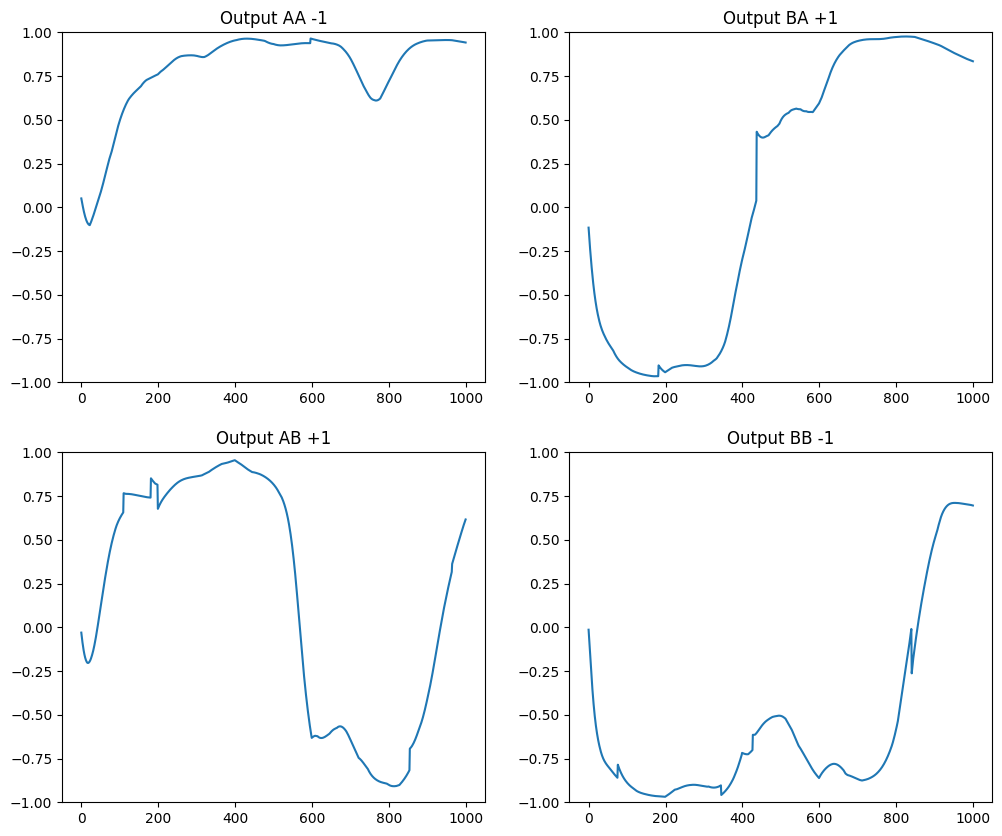

In [10]:
# Perform the four different trials successively
initialAA, errorAA = dnms_trial(0, [0, 0], -0.98, 0.0, record=True)
initialAB, errorAB = dnms_trial(0, [0, 1], +0.98, 0.0, record=True)
initialBA, errorBA = dnms_trial(0, [1, 0], +0.98, 0.0, record=True)
initialBB, errorBB = dnms_trial(0, [1, 1], -0.98, 0.0, record=True)

plt.figure(figsize=(12, 10))
ax = plt.subplot(221)
ax.plot(initialAA[:, OUTPUT_NEURON])
ax.set_ylim((-1., 1.))
ax.set_title('Output AA -1')
ax = plt.subplot(222)
ax.plot(initialBA[:, OUTPUT_NEURON])
ax.set_ylim((-1., 1.))
ax.set_title('Output BA +1')
ax = plt.subplot(223)
ax.plot(initialAB[:, OUTPUT_NEURON])
ax.set_ylim((-1., 1.))
ax.set_title('Output AB +1')
ax = plt.subplot(224)
ax.plot(initialBB[:, OUTPUT_NEURON])
ax.set_ylim((-1., 1.))
ax.set_title('Output BB -1')
plt.show()

We can now run the simulation for 1500 trials. Beware, this can take 15 to 20 minutes.

In [11]:
# Compute the mean reward per trial
R_mean = - np.ones((2, 2))
alpha = 0.75

# Many trials of each type
record_rewards = []

for trial in (t := tqdm(range(10000))):

    # Perform the four different trials successively
    _, rewardAA = dnms_trial(trial, [0, 0], -0.98, R_mean[0, 0])

    _, rewardAB = dnms_trial(trial, [0, 1], +0.98, R_mean[0, 1])

    _, rewardBA = dnms_trial(trial, [1, 0], +0.98, R_mean[1, 0])

    _, rewardBB = dnms_trial(trial, [1, 1], -0.98, R_mean[1, 1])

    # Reward
    reward = np.array([[rewardAA, rewardBA], [rewardBA, rewardBB]])

    # Update mean reward
    R_mean = alpha * R_mean + (1.- alpha) * reward

    record_rewards.append(R_mean)
    t.set_description(
        f'AA: {R_mean[0, 0]:.2f} AB: {R_mean[0, 1]:.2f} BA: {R_mean[1, 0]:.2f} BB: {R_mean[1, 1]:.2f}'
    )


AA: -0.07 AB: -0.28 BA: -0.28 BB: -0.06: 100%|██████████| 10000/10000 [13:32<00:00, 12.31it/s]


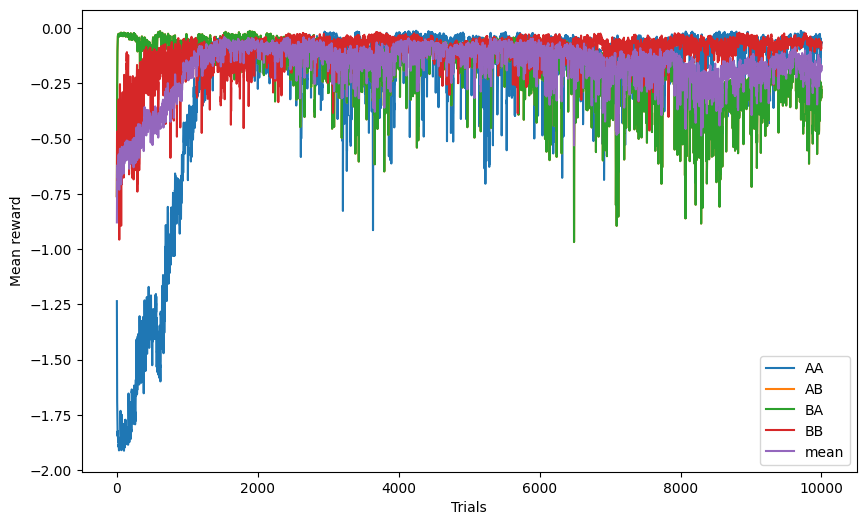

In [12]:
record_rewards = np.array(record_rewards)

plt.figure(figsize=(10, 6))
plt.plot(record_rewards[:, 0, 0], label='AA')
plt.plot(record_rewards[:, 0, 1], label='AB')
plt.plot(record_rewards[:, 1, 0], label='BA')
plt.plot(record_rewards[:, 1, 1], label='BB')
plt.plot(record_rewards.mean(axis=(1,2)), label='mean')

plt.xlabel("Trials")
plt.ylabel("Mean reward")
plt.legend()
plt.show()

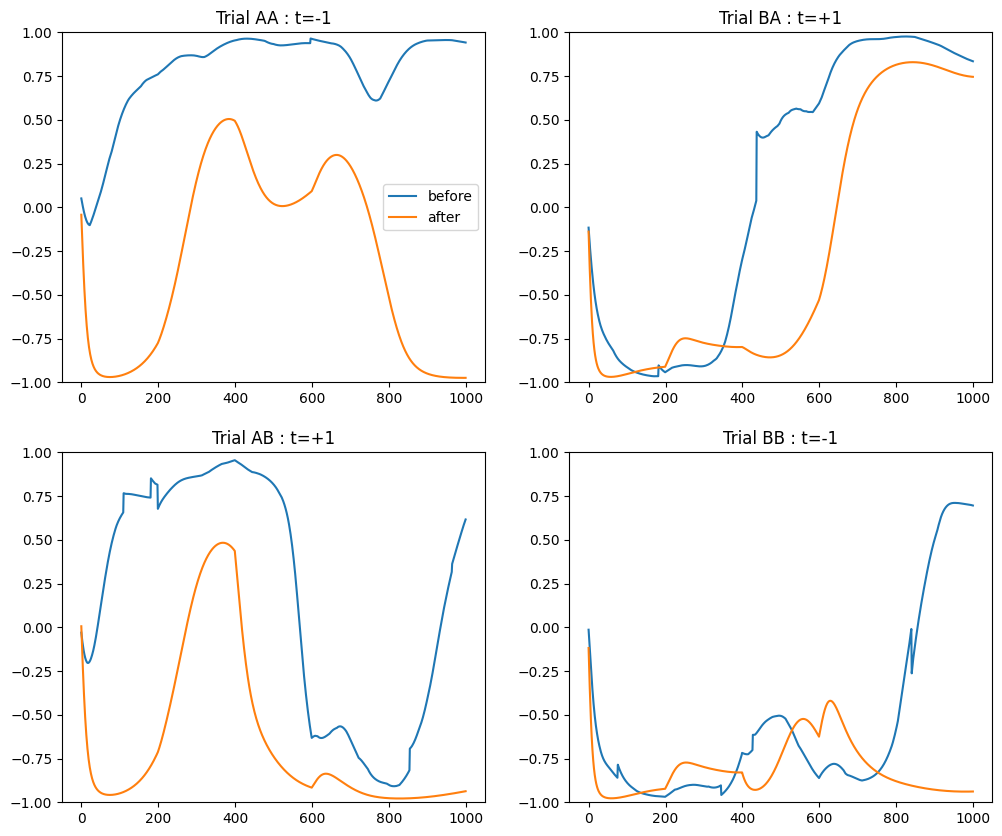

In [13]:
# Perform the four different trials without perturbation for testing
recordsAA, errorAA = dnms_trial(0, [0, 0], -0.98, 0.0, record=True, perturbation=False)
recordsAB, errorAB = dnms_trial(0, [0, 1], +0.98, 0.0, record=True, perturbation=False)
recordsBA, errorBA = dnms_trial(0, [1, 0], +0.98, 0.0, record=True, perturbation=False)
recordsBB, errorBB = dnms_trial(0, [1, 1], -0.98, 0.0, record=True, perturbation=False)

plt.figure(figsize=(12, 10))
plt.subplot(221)
plt.plot(initialAA[:, OUTPUT_NEURON], label='before')
plt.plot(recordsAA[:, OUTPUT_NEURON], label='after')
plt.legend()
plt.ylim((-1., 1.))
plt.title('Trial AA : t=-1')
plt.subplot(222)
plt.plot(initialBA[:, OUTPUT_NEURON], label='before')
plt.plot(recordsBA[:, OUTPUT_NEURON], label='after')
plt.ylim((-1., 1.))
plt.title('Trial BA : t=+1')
plt.subplot(223)
plt.plot(initialAB[:, OUTPUT_NEURON], label='before')
plt.plot(recordsAB[:, OUTPUT_NEURON], label='after')
plt.ylim((-1., 1.))
plt.title('Trial AB : t=+1')
plt.subplot(224)
plt.plot(initialBB[:, OUTPUT_NEURON], label='before')
plt.plot(recordsBB[:, OUTPUT_NEURON], label='after')
plt.ylim((-1., 1.))
plt.title('Trial BB : t=-1')
plt.show()